In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
#import torch
import os
import glob
import PIL
import imageio
import seaborn as sn
import matplotlib.pyplot as plt
#import torchvision.transforms as transforms

from numpy import savez_compressed
from PIL import Image
#from google.colab import drive
#from google.colab import files
from scipy import misc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from tensorflow.keras.layers import concatenate
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from IPython.display import HTML, display


In [ ]:

#%% Функции для загрузки данных

def load_signals_attributes(input_path, display=False):
  print('[INFO] Загрузка…\n')
  cols = ["N1", "N2", "class"]
  df = pd.read_csv(input_path, sep=" ", header=None, names=cols)
  print('[INFO] Attributes loaded successfully!\n')
  if display == True:
    df.head()
  return df

def load_signals_images(input_path):
  print(os.listdir(input_path))
  # Директория - это список абсолютных путей ко всем файлам, лежащим в папке
  # Сортируем файлы по длине их названия
  print('[INFO] Сортировка файлов в директории...\n')
  path = input_path+"/*.png"
  directory = sorted(glob.glob(path), key=len) 

  # Далее сортируем их численно (numerically), то есть сортируем численные названия
  # по возрастанию
  directory = sorted(glob.glob(path), 
                    key=lambda x: int(os.path.basename(x).split('.')[0]))

  def get_key(fp):
      filename = os.path.splitext(os.path.basename(fp))[0]
      int_part = filename.split()[0]
      return int(int_part)
  directory = sorted(glob.glob(path), 
                    key=get_key)
  # В конце получаем отсортированную по возрастанию директорию, с которой считываем
  # картинки в массив

  print('[INFO] Загрузка изображений в массив...\n')
  Im = []
  #bar = display(progress(0, len(directory)), display_id=True) # Progress Bar
  counter = 0
  for image_path in directory:
    Im.append(imageio.imread(image_path))
    counter += 1
    #bar.update(progress(counter, len(directory))) # Update Progress
  # Масштабируем  
  Im = np.array(Im)/255.0
  print("[INFO] Датасет загружен")
  return Im


#%% Функции для создания моделей и оценки их результатов

def results(history, model, testX, testY):
  plt.rcParams['figure.dpi'] = 100
  #dataset_labels=np.array(['Comb', 'Inner', 'Normal', 'Outer', 'Ball'])
  #dataset_labels=np.array(['Normal','Inner', 'Outer', 'Ball', 'Comb'])
  dataset_labels=np.array(['N-N','I-N', 'O-N', 'B-N', 'C-N', 'N-I', 'N-O', 'N-B', 'N-C'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.history['loss']))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy', linestyle="--")
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss', linestyle="--")
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  

  test_loss, test_acc = model.evaluate(testX, testY, verbose=2)

  # Confusion Matrix
  predictions = model.predict(testX)
  confusion = confusion_matrix(np.argmax(testY, axis=1), 
                              np.argmax(predictions, axis=1))
  print('CONFUSION MATRIX\n', confusion, '\n\n')
  # normalize confustion matrix [0 1]
  # confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
  df_cm = pd.DataFrame(confusion, 
                       dataset_labels, 
                       dataset_labels)
  sn.set(font_scale=1.2) # for label size
  plt.figure(figsize=(4,4))
  sn.heatmap(df_cm, 
             annot=True, 
             annot_kws={"size": 10}, # font size
             fmt = "d",
             #fmt='.2f', # precision (2 digits)
             linewidths=.5,
             cmap="YlGnBu") 
  plt.title(str(model.name))
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

  print('CLASSIFICATION REPORT\n',
        classification_report(np.argmax(testY, axis=1), 
                              np.argmax(predictions, axis=1), 
                              target_names=dataset_labels))



In [ ]:

def create_mlp(dim, regress=False):
	# Создаем модель
    model = Sequential()
    model.add(Dense(16, input_dim=dim, activation="relu"))
   # model.add(Dropout(0.2))
    model.add(Dense(8, activation="relu"))
    #model.add(Dense(16, activation="relu"))

   
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(9))
    return model

def create_cnn(width, height, depth, filters=(32, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(16)(x)
    x = Activation("relu")(x)
    
    # check to see if the regression node should be added
    if regress:
        x = Dense(9)(x)
        
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model    

# def create_cnn_1(regress=False):
#   dropout = 0.6
#   model = Sequential()
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(Dropout(dropout))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(Dropout(dropout))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#   model.add(layers.Flatten())
#   model.add(Dropout(dropout))
#   model.add(layers.Dense(64, activation='relu'))

#   if regress:
#     model.add(layers.Dense(5)) # , activation='softmax'
#   return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#%% Загрузка данных
data_root='/content/drive/My Drive/data/twobearingsdataset/twobearings20hht'

Mounted at /content/drive


In [ ]:
attr = load_signals_attributes(data_root+"/LongData20.txt")
#%%
images = load_signals_images(data_root)


#%% Делим на обучающую и тестовую выборки
split = train_test_split(attr, images, test_size=0.15, random_state=42)
(AttrX, testAttrX, ImagesX, testImagesX) = split

split = train_test_split(AttrX, ImagesX, test_size=0.15, random_state=42)
(trainAttrX,validAttrX, trainImagesX, validImagesX) = split

continuous = ["N1", "N2"]

# Нормализация в диапазоне [0 1]
cs = MinMaxScaler()
trainAttrXnorm = cs.fit_transform(trainAttrX[continuous])
validAttrXnorm = cs.fit_transform(validAttrX[continuous])
testAttrXnorm = cs.transform(testAttrX[continuous])

zipBinarizer = LabelBinarizer().fit(attr["class"])
trainY = zipBinarizer.transform(trainAttrX["class"])
validY = zipBinarizer.transform(validAttrX["class"])
testY = zipBinarizer.transform(testAttrX["class"])

print(trainAttrX.shape)
print(validAttrX.shape)
print(testAttrX.shape)
print(trainImagesX.shape)
print(validImagesX.shape)
print(testImagesX.shape)


[INFO] Загрузка…

[INFO] Attributes loaded successfully!

['6202.png', '6203.png', '6204.png', '6205.png', '6206.png', '6207.png', '6208.png', '6209.png', '6210.png', '6211.png', '6212.png', '6213.png', '6214.png', '6215.png', '6216.png', '6217.png', '6218.png', '6219.png', '6220.png', '6221.png', '6222.png', '6223.png', '6224.png', '6225.png', '6226.png', '6227.png', '6228.png', '6229.png', '6230.png', '6231.png', '6232.png', '6233.png', '6234.png', '6235.png', '6236.png', '6237.png', '6238.png', '6239.png', '6240.png', '6241.png', '6242.png', '6243.png', '6244.png', '6245.png', '6246.png', '6247.png', '6248.png', '6249.png', '6250.png', '6251.png', '6252.png', '6253.png', '6254.png', '6255.png', '6256.png', '6257.png', '6258.png', '6259.png', '6260.png', '6261.png', '6262.png', '6263.png', '6264.png', '6265.png', '6266.png', '6267.png', '6268.png', '6269.png', '6270.png', '6271.png', '6272.png', '6273.png', '6274.png', '6275.png', '6276.png', '6277.png', '6278.png', '6279.png', '6280

In [ ]:
print(attr)

       N1   N2  class
0      61   53      1
1     120  110      2
2      91   70      3
3      92   68      4
4     213  288      5
...   ...  ...    ...
7195  187  278      5
7196  126   92      6
7197  171   55      7
7198  134   62      8
7199  143  167      9

[7200 rows x 3 columns]


[INFO] Creating Hybrid CNN+MLP...
[INFO] Compiling model...
[INFO] Training model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
261/261 [==============================] - 6s 14ms/step - loss: 2.0867 - accuracy: 0.2313 - val_loss: 2.2138 - val_accuracy: 0.1383
Epoch 2/200
261/261 [==============================] - 2s 9ms/step - loss: 1.7037 - accuracy: 0.4154 - val_loss: 1.6391 - val_accuracy: 0.4510
Epoch 3/200
261/261 [==============================] - 2s 9ms/step - loss: 1.5184 - accuracy: 0.4958 - val_loss: 1.3035 - val_accuracy: 0.6503
Epoch 4/200
261/261 [==============================] - 2s 9ms/step - loss: 1.3681 - accuracy: 0.5632 - val_loss: 1.1300 - val_accuracy: 0.6950
Epoch 5/200
261/261 [==============================] - 2s 9ms/step - loss: 1.2517 - accuracy: 0.6140 - val_loss: 1.0162 - val_accuracy: 0.7048
Epoch 6/200
261/261 [==============================] - 2s 9ms/step - loss: 1.1301 - accuracy: 0.6399 - val_loss: 0.9048 - val_accuracy: 0.7233
Epoch 7/200
261/261 [==============================] - 2s 9ms/step - loss: 1.0239 - accuracy: 0.6761 - val_loss: 0.7847 - val_accuracy: 0.723

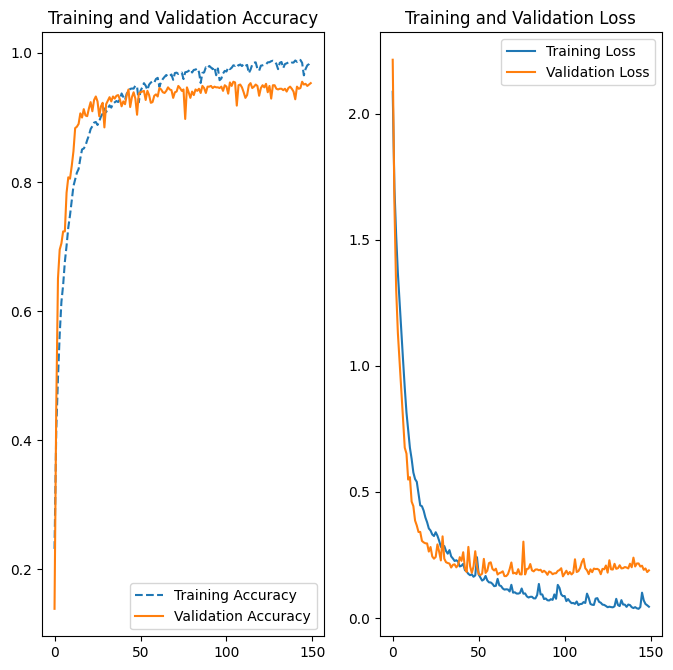

34/34 - 0s - loss: 0.2185 - accuracy: 0.9343 - 475ms/epoch - 14ms/step
CONFUSION MATRIX
 [[120   0   0   0   0   0   0   0   0]
 [  0 113   0   2   0   0   0   0   0]
 [  2   1  91  14   0   0   0   1   0]
 [  0   4  16  91   0   0   1   5   0]
 [  0   0   0   0 131   0   0   0   0]
 [  0   0   1   0   0 134   6   0   0]
 [  0   0   0   0   0   4 102   3   0]
 [  1   0   0   3   0   1   4 112   0]
 [  0   0   0   0   1   1   0   0 115]] 




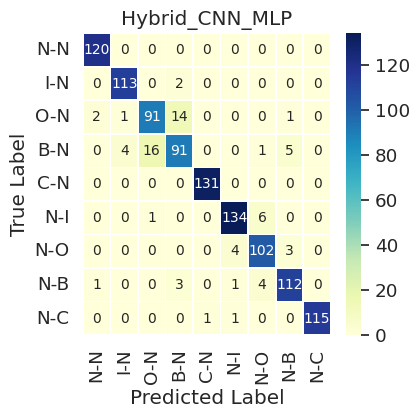

CLASSIFICATION REPORT
               precision    recall  f1-score   support

         N-N       0.98      1.00      0.99       120
         I-N       0.96      0.98      0.97       115
         O-N       0.84      0.83      0.84       109
         B-N       0.83      0.78      0.80       117
         C-N       0.99      1.00      1.00       131
         N-I       0.96      0.95      0.95       141
         N-O       0.90      0.94      0.92       109
         N-B       0.93      0.93      0.93       121
         N-C       1.00      0.98      0.99       117

    accuracy                           0.93      1080
   macro avg       0.93      0.93      0.93      1080
weighted avg       0.93      0.93      0.93      1080



In [ ]:
# %% Обучение Hybrid
print('[INFO] Creating Hybrid CNN+MLP...')
mlp = create_mlp(trainAttrXnorm.shape[1], regress=False)
cnn = create_cnn(32, 32, 3, regress=False) 

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(16, activation="relu")(combinedInput)
x = Dense(9)(x)

checkpoint_path='bestmodel.h5'

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=50, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

model_mixed = Model(inputs=[mlp.input, cnn.input], 
                    outputs=x, 
                    name="Hybrid_CNN_MLP")

print('[INFO] Compiling model...')
opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-3 / 200)
model_mixed.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
print("[INFO] Training model...")
history_model_mixed = model_mixed.fit(
              x=[trainAttrXnorm, trainImagesX], y=trainY,
              validation_data=([validAttrXnorm, validImagesX], validY), 
              batch_size = 20,
              epochs=200,
              callbacks=[keras_callbacks]
)
#%
best_model_mixed = load_model(checkpoint_path)

# это лучшая модель
results(history_model_mixed, 
        best_model_mixed, 
        [testAttrXnorm, testImagesX], 
        testY)

#% это последняя модель
# results(history_model_mixed, 
#         model_mixed, 
#         [testAttrXnorm, testImagesX], 
#         testY)


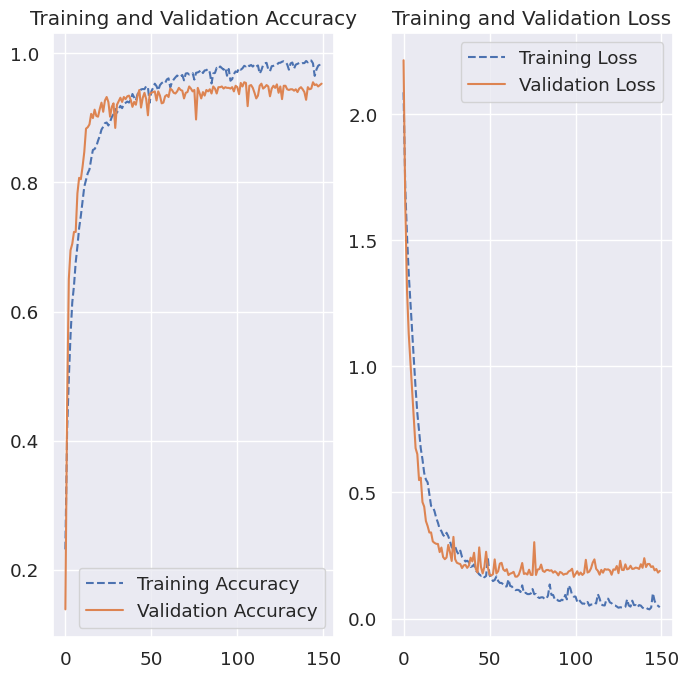

34/34 - 0s - loss: 0.2185 - accuracy: 0.9343 - 161ms/epoch - 5ms/step
CONFUSION MATRIX
 [[120   0   0   0   0   0   0   0   0]
 [  0 113   0   2   0   0   0   0   0]
 [  2   1  91  14   0   0   0   1   0]
 [  0   4  16  91   0   0   1   5   0]
 [  0   0   0   0 131   0   0   0   0]
 [  0   0   1   0   0 134   6   0   0]
 [  0   0   0   0   0   4 102   3   0]
 [  1   0   0   3   0   1   4 112   0]
 [  0   0   0   0   1   1   0   0 115]] 




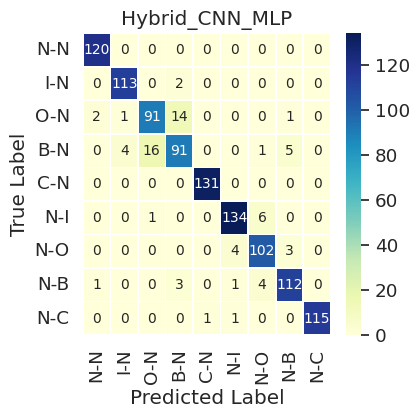

CLASSIFICATION REPORT
               precision    recall  f1-score   support

         N-N       0.98      1.00      0.99       120
         I-N       0.96      0.98      0.97       115
         O-N       0.84      0.83      0.84       109
         B-N       0.83      0.78      0.80       117
         C-N       0.99      1.00      1.00       131
         N-I       0.96      0.95      0.95       141
         N-O       0.90      0.94      0.92       109
         N-B       0.93      0.93      0.93       121
         N-C       1.00      0.98      0.99       117

    accuracy                           0.93      1080
   macro avg       0.93      0.93      0.93      1080
weighted avg       0.93      0.93      0.93      1080



In [ ]:
# это лучшая модель
results(history_model_mixed, 
        best_model_mixed, 
        [testAttrXnorm, testImagesX], 
        testY)

[INFO] Creating CNN...
[INFO] Compiling model...
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


261/261 [==============================] - 3s 9ms/step - loss: 2.0704 - accuracy: 0.2372 - val_loss: 2.0879 - val_accuracy: 0.2102
Epoch 2/2
261/261 [==============================] - 2s 8ms/step - loss: 1.6778 - accuracy: 0.3952 - val_loss: 1.5930 - val_accuracy: 0.5251


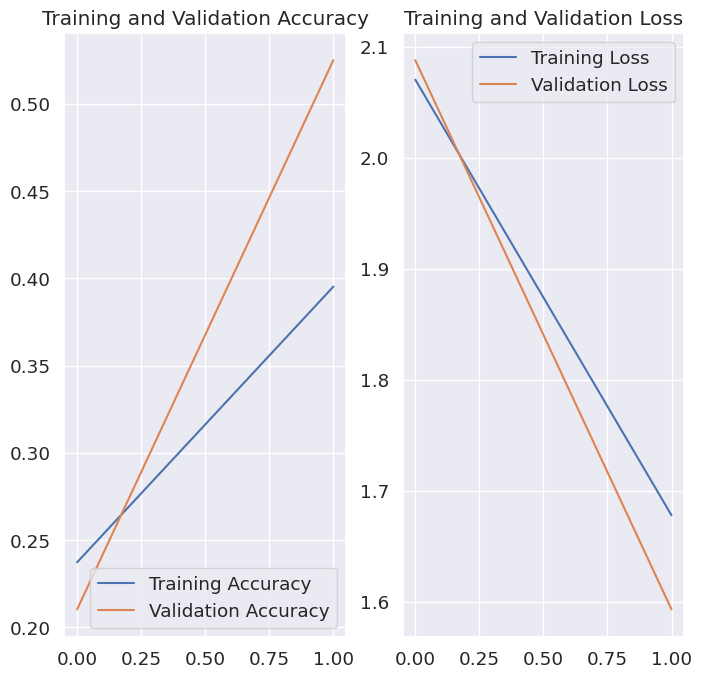

34/34 - 0s - loss: 1.5701 - accuracy: 0.5639 - 341ms/epoch - 10ms/step
CONFUSION MATRIX
 [[117   0   1   0   2   0   0   0   0]
 [  0  72  18  12   7   2   2   0   2]
 [  2  15  60  18   4   3   7   0   0]
 [  0   6  21  53   4  17  13   0   3]
 [  0   1   0   0 115   0   0   0  15]
 [  1   0   6  18   9  84   3   0  20]
 [  0   4   1  44   0  47   9   0   4]
 [  0   1   6  46   1  47  20   0   0]
 [  0   0   0   2  10   6   0   0  99]] 




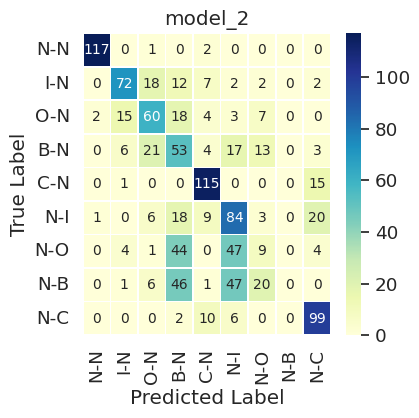

CLASSIFICATION REPORT
               precision    recall  f1-score   support

         N-N       0.97      0.97      0.97       120
         I-N       0.73      0.63      0.67       115
         O-N       0.53      0.55      0.54       109
         B-N       0.27      0.45      0.34       117
         C-N       0.76      0.88      0.81       131
         N-I       0.41      0.60      0.48       141
         N-O       0.17      0.08      0.11       109
         N-B       0.00      0.00      0.00       121
         N-C       0.69      0.85      0.76       117

    accuracy                           0.56      1080
   macro avg       0.50      0.56      0.52      1080
weighted avg       0.51      0.56      0.53      1080

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#%% CNN only
print('[INFO] Creating CNN...')
model_cnn = create_cnn(32, 32, 3, regress=True)
print('[INFO] Compiling model...')

checkpoint_path='bestcnn.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=50, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-3 / 200)
model_cnn.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_model_cnn = model_cnn.fit(
              x=trainImagesX, y=trainY,
              validation_data=(validImagesX, validY),
              batch_size =20,
              epochs=2,
              callbacks=[keras_callbacks]
)


#%
best_model_cnn = load_model(checkpoint_path)

# это лучшая модель
results(history_model_cnn, 
        best_model_cnn, 
        testImagesX, 
        testY)


#% это последняя модель
# results(history = history_model_cnn, 
#         model = model_cnn, 
#         testX = testImagesX, 
#         testY = testY)

#%% CNN Summary
best_model_cnn.summary()


In [ ]:
#%% MLP only
print('[INFO] Creating MLP...')
model_mlp = create_mlp(trainAttrXnorm.shape[1], regress=True)

checkpoint_path='bestmlp.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=50, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

print('[INFO] Compiling model...')
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model_mlp.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
print("[INFO] Training model...")
history_model_mlp = model_mlp.fit(
              x=trainAttrXnorm, y=trainY,
              validation_data=(validAttrXnorm, validY),
              epochs=500, 
              callbacks=[keras_callbacks])

#%

best_model_mlp = load_model(checkpoint_path)

results(history = history_model_mlp, 
        model = best_model_mlp, 
        testX = testAttrXnorm, 
        testY = testY)

#%% это последняя модель
# results(history = history_model_mlp, 
#         model = model_mlp, 
#         testX = testAttrXnorm, 
#         testY = testY)



